In [1]:
import os
import sopa
import dask
import spatialdata_plot
import spatialdata as sd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Preprocessing

In [3]:
#sopa.settings.parallelization_backend = "dask"
#sopa.settings.dask_client_kwargs["n_workers"] = 4
sopa.settings.parallelization_backend = None

In [ ]:
# Load the COMET image, here we are assuming the background subtraction has been performed
# and the elution channels have been removed
img = sopa.io.ome_tif("DATA/no_elution.ome.tiff", as_image=False)

In [2]:
# Set the chanenl names 
sopa_marker_genes = [
 'DAPI',
 'CD3',
 'FOXP3',
 'CD4',
 'CD8',
 'CD20',
 'CD56',
 'CD11c',
 'CD68',
 'aSMA',
 'PDL1',
 'CD45',
 'PD1',
 'Ki67'
]

In [ ]:
img.set_channel_names("no_elution", sopa_marker_genes, write=True)

In [ ]:
# Segment the tissue on a lower resolution pyramid level, to identify the areas to perform cell segmentation on
sopa.segmentation.tissue(sdata=img, image_key="no_elution", channel="DAPI", mode="staining", level=4,
                         allow_holes=False, clip_parameters=(0.99, 4), expand_radius_ratio=0.1)

In [18]:
# Extract the bounding boxes of the 2 largest pieces of tissue:
# 1) Calculate the scaling factor between the pyramid level used for tissue segmentation and the full resolution
# 2) Get the bounding boxes from the regions_of_interest ROIs polygons we obtained from the tissue segmentation
# 3) Scale the bounding boxes to match the full resolution image
# 4) Calculate the area to find the 3 kargest bounding boxes
factor = img["no_elution"]["scale0"].dims["x"] / img["no_elution"]["scale4"].dims["x"]
samples =  img["region_of_interest"].bounds * factor
samples["area"] = (samples["maxx"] - samples["minx"]) * (samples["maxy"] - samples["miny"])
#samples = samples.iloc[samples["area"].nlargest(2).index]
print(samples)
print(img["region_of_interest"].bounds)

           minx          miny          maxx          maxy          area
4  11448.853818  10168.767796  26329.684892  18201.138655  1.195284e+08
2  24953.761345  23977.695753  33066.137580  34650.244032  8.657973e+07
          minx         miny         maxx         maxy
4   715.505279   635.505279  1645.494721  1137.494721
2  1559.505279  1498.505279  2066.494721  2165.494721


In [ ]:
# Discard all other pieces of tissue befor the segmentation
img["region_of_interest"] = img["region_of_interest"].iloc[samples.index,:]
img["region_of_interest"]

In [ ]:
# Divide the tissue in patches, to perform the segmentation on
sopa.make_image_patches(img, patch_width=1000, patch_overlap=100)

In [ ]:
# Generate some rasters to plot the areas to be segmented
img["comet_raster"] = sd.rasterize(img["no_elution"]["scale0"].image[0,...], target_width=2000, target_coordinate_system="global", axes=("x", "y"), min_coordinate=[0,0], max_coordinate=[44643,44643])
img["tissue_raster"] = sd.rasterize(img["region_of_interest"], target_width=2000, target_coordinate_system="global", axes=("x", "y"), min_coordinate=[0,0], max_coordinate=[44643,44643])
img["patches_raster"] = sd.rasterize(img["image_patches"], target_width=2000, target_coordinate_system="global", axes=("x", "y"), min_coordinate=[0,0], max_coordinate=[44643,44643])

In [ ]:
# DAPI Image, Tissue to be segmented, Segmentation patches
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))
axs[0].imshow(img["comet_raster"].data.squeeze())
axs[1].imshow(img["tissue_raster"].data.squeeze())
axs[2].imshow(img["patches_raster"].data.squeeze())

In [ ]:
# Gets the mean pixel values for each channel in each cell as an AnnData object, no cells are discarded
img = img.subset(["no_elution", "image_patches", "region_of_interest"])
img

In [ ]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img.write(file_path="SOPA_PRESEG.zarr", overwrite=True)

## Segmentation

In [4]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img = sd.read_zarr("SOPA_PRESEG.zarr")
img

version mismatch: detected: RasterFormatV02, requested: FormatV04
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/crea

SpatialData object, with associated Zarr store: /omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/SOPA_PRESEG.zarr
├── Images
│     └── 'no_elution': DataTree[cyx] (14, 44643, 44643), (14, 22321, 22321), (14, 11160, 11160), (14, 5580, 5580), (14, 2790, 2790)
├── Shapes
│     ├── 'cells': GeoDataFrame shape: (46471, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (220, 3) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (46471, 14)
with coordinate systems:
    ▸ 'global', with elements:
        no_elution (Images), cells (Shapes), image_patches (Shapes), region_of_interest (Shapes)

In [5]:
# Perform the segmentation. Assumes that:
# - We are running on a GPU node
# - The cpsam model is present at: ~/.cellpose/models/cpsam (download from: https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam?download=true)
sopa.segmentation.cellpose(sdata=img, image_key="no_elution", channels=["DAPI"],
                           diameter=20, gpu=True, delete_cache=True, recover=False,
                           flow_threshold=2, cellprob_threshold=-6, clip_limit=0.0,
                           clahe_kernel_size=None, gaussian_sigma=1, key_added="cells")



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.2 
torch version:  	2.8.0+cu128! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




[INFO] (sopa.segmentation.methods._cellpose) You use cellpose=4.0.6, which requires a `pretrained_model`. Defaulting to 'cpsam'.
[WARNING] (sopa._settings) Running without parallelization backend can be slow. Consider using a backend, e.g. via `sopa.settings.parallelization_backend = 'dask'`, or `export SOPA_PARALLELIZATION_BACKEND=dask`.
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
no seeds found in get_masks_torch - no masks found.
Resizing is depricated in v4.0.1+
[WARNING] (sopa.shapes._vectorize) No cell was returned by the segmentation
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is depricated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is depricated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will b

In [6]:
# Gets the mean pixel values for each channel in each cell as an AnnData object, no cells are discarded
sopa.aggregation.aggregate(img, image_key="no_elution", shapes_key="cells", aggregate_channels=True, min_intensity_ratio=0)

[INFO] (sopa.aggregation.channels) Aggregating channels intensity over 46471 cells with mode='average'


[########################################] | 100% Completed | 106.35 s


/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/spatialdata/_core/_elements.py:108: UserWarning: Key `cells` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [7]:
# Gets the mean pixel values for each channel in each cell as an AnnData object, no cells are discarded
img = img.subset(["no_elution", "cells", "image_patches", "region_of_interest", "table"])

In [8]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img.write(file_path="SOPA_NO_ELUTION_SEG_FIX2.zarr", overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside SOPA_NO_ELUTION_SEG_FIX2.zarr). Please see the documentation of `is_self_contained()` to
         understand the implications of working with SpatialData objects that are not self-contained.              
INFO     The Zarr backing store has been changed from None the new file path: SOPA_NO_ELUTION_SEG_FIX2.zarr        


## Analysis
If you have processed the data with the nf-core pipeline, you can start processsing from here.

In [9]:
# Switch to an on-disk zarr object to improve performance by first writing and then reading
img = sd.read_zarr("SOPA_NO_ELUTION_SEG_FIX2.zarr")
img

version mismatch: detected: RasterFormatV02, requested: FormatV04
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/zarr/crea

SpatialData object, with associated Zarr store: /omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/SOPA_NO_ELUTION_SEG_FIX2.zarr
├── Images
│     └── 'no_elution': DataTree[cyx] (14, 44643, 44643), (14, 22321, 22321), (14, 11160, 11160), (14, 5580, 5580), (14, 2790, 2790)
├── Shapes
│     ├── 'cells': GeoDataFrame shape: (46471, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (220, 3) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (46471, 14)
with coordinate systems:
    ▸ 'global', with elements:
        no_elution (Images), cells (Shapes), image_patches (Shapes), region_of_interest (Shapes)

In [10]:
# Plot a small cropped area to check the segmentation
#crop = img.query.bounding_box(axes = ("x", "y"), min_coordinate = [30000, 30000], max_coordinate = [31000, 31000], target_coordinate_system="global")
#crop.pl.render_images("no_elution", channel='DAPI').pl.render_shapes("cells", fill_alpha = 0, outline_width=1.5, outline_color='#FF0000', outline_alpha=1).pl.show()
#del(crop)

In [29]:
# Produces an expression table withou DAPI for the clustering
img["nodapi"] = img["table"][:, 1:].copy()

/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/spatialdata/_core/_elements.py:128: UserWarning: Key `nodapi` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [38]:
# Test manual annotation of cells with hard thresholds
# The order the thresholds are applied matters! The last ones ovewrite the first ones.
annotations = img["table"].to_df()
annotations["cell_type"] = "Cells Other"
annotations.loc[:, "DAPI"] = annotations.DAPI > 300
annotations.loc[:, "CD45"] = annotations.CD45 > 200
annotations.loc[:, "CD3"] = annotations.CD3 > 300
annotations.loc[:, "CD4"] = annotations.CD4 > 300
annotations.loc[:, "CD8"] = annotations.CD8 > 500
annotations.loc[:, "FOXP3"] = annotations.FOXP3 > 600
annotations.loc[:, "PD1"] = annotations.PD1 > 200
annotations.loc[:, "PDL1"] = annotations.PDL1 > 200
annotations.loc[:, "CD68"] = annotations.CD68 > 200
annotations.loc[:, "CD56"] = annotations.CD56 > 400
annotations.loc[:, "CD11c"] = annotations.CD11c > 200
annotations.loc[:, "Ki67"] = annotations.Ki67 > 200
annotations.loc[:, "aSMA"] = annotations.aSMA > 200

annotations.loc[annotations.Ki67 == True, "cell_type"] = "Proliferating"
annotations.loc[annotations.CD11c == True, "cell_type"] = "Dendritic"
annotations.loc[annotations.aSMA == True, "cell_type"] = "Fibroblast"
annotations.loc[annotations.CD56 == True, "cell_type"] = "NK"
annotations.loc[annotations.CD68 == True, "cell_type"] = "Macrophages"
annotations.loc[annotations.CD3 & annotations.CD8 & annotations.PD1 & ~annotations.CD4, "cell_type"] = "CD8+ PD1+ T cells"
annotations.loc[annotations.CD3 & annotations.CD8 & ~annotations.PD1 & ~annotations.CD4, "cell_type"] = "CD8+ PD1- T cells"
annotations.loc[annotations.CD3 & annotations.CD4 & annotations.FOXP3, "cell_type"] = "CD4+ FOXP3+ T cells"
annotations.loc[annotations.CD3 & annotations.CD4 & ~annotations.FOXP3, "cell_type"] = "CD4+ FOXP3- T cells"
annotations.loc[annotations.CD3 & annotations.CD68 & annotations.aSMA & annotations.Ki67, "cell_type"] = "B Excluded Overlap"
annotations.loc[annotations.DAPI == False, "cell_type"] = "B Excluded DAPI"
img["table"].obs["cell_type"] = annotations["cell_type"]
img["nodapi"].obs["cell_type"] = annotations["cell_type"]

/ssd/m031i/42915283/cluster_tmp/ipykernel_1408722/159624218.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True  True ...  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annotations.loc[:, "DAPI"] = annotations.DAPI > 300
/ssd/m031i/42915283/cluster_tmp/ipykernel_1408722/159624218.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annotations.loc[:, "CD45"] = annotations.CD45 > 200
/ssd/m031i/42915283/cluster_tmp/ipykernel_1408722/159624218.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float

In [31]:
# Generate a NN neighbour grap and the UMAP embeddings
sc.pp.neighbors(img["nodapi"])
sc.tl.umap(img["nodapi"])

/omics/odcf/analysis/OE0536_projects_temp/spatialomicsdata/MICHELE/LIBAN/SOPA/sopa_analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


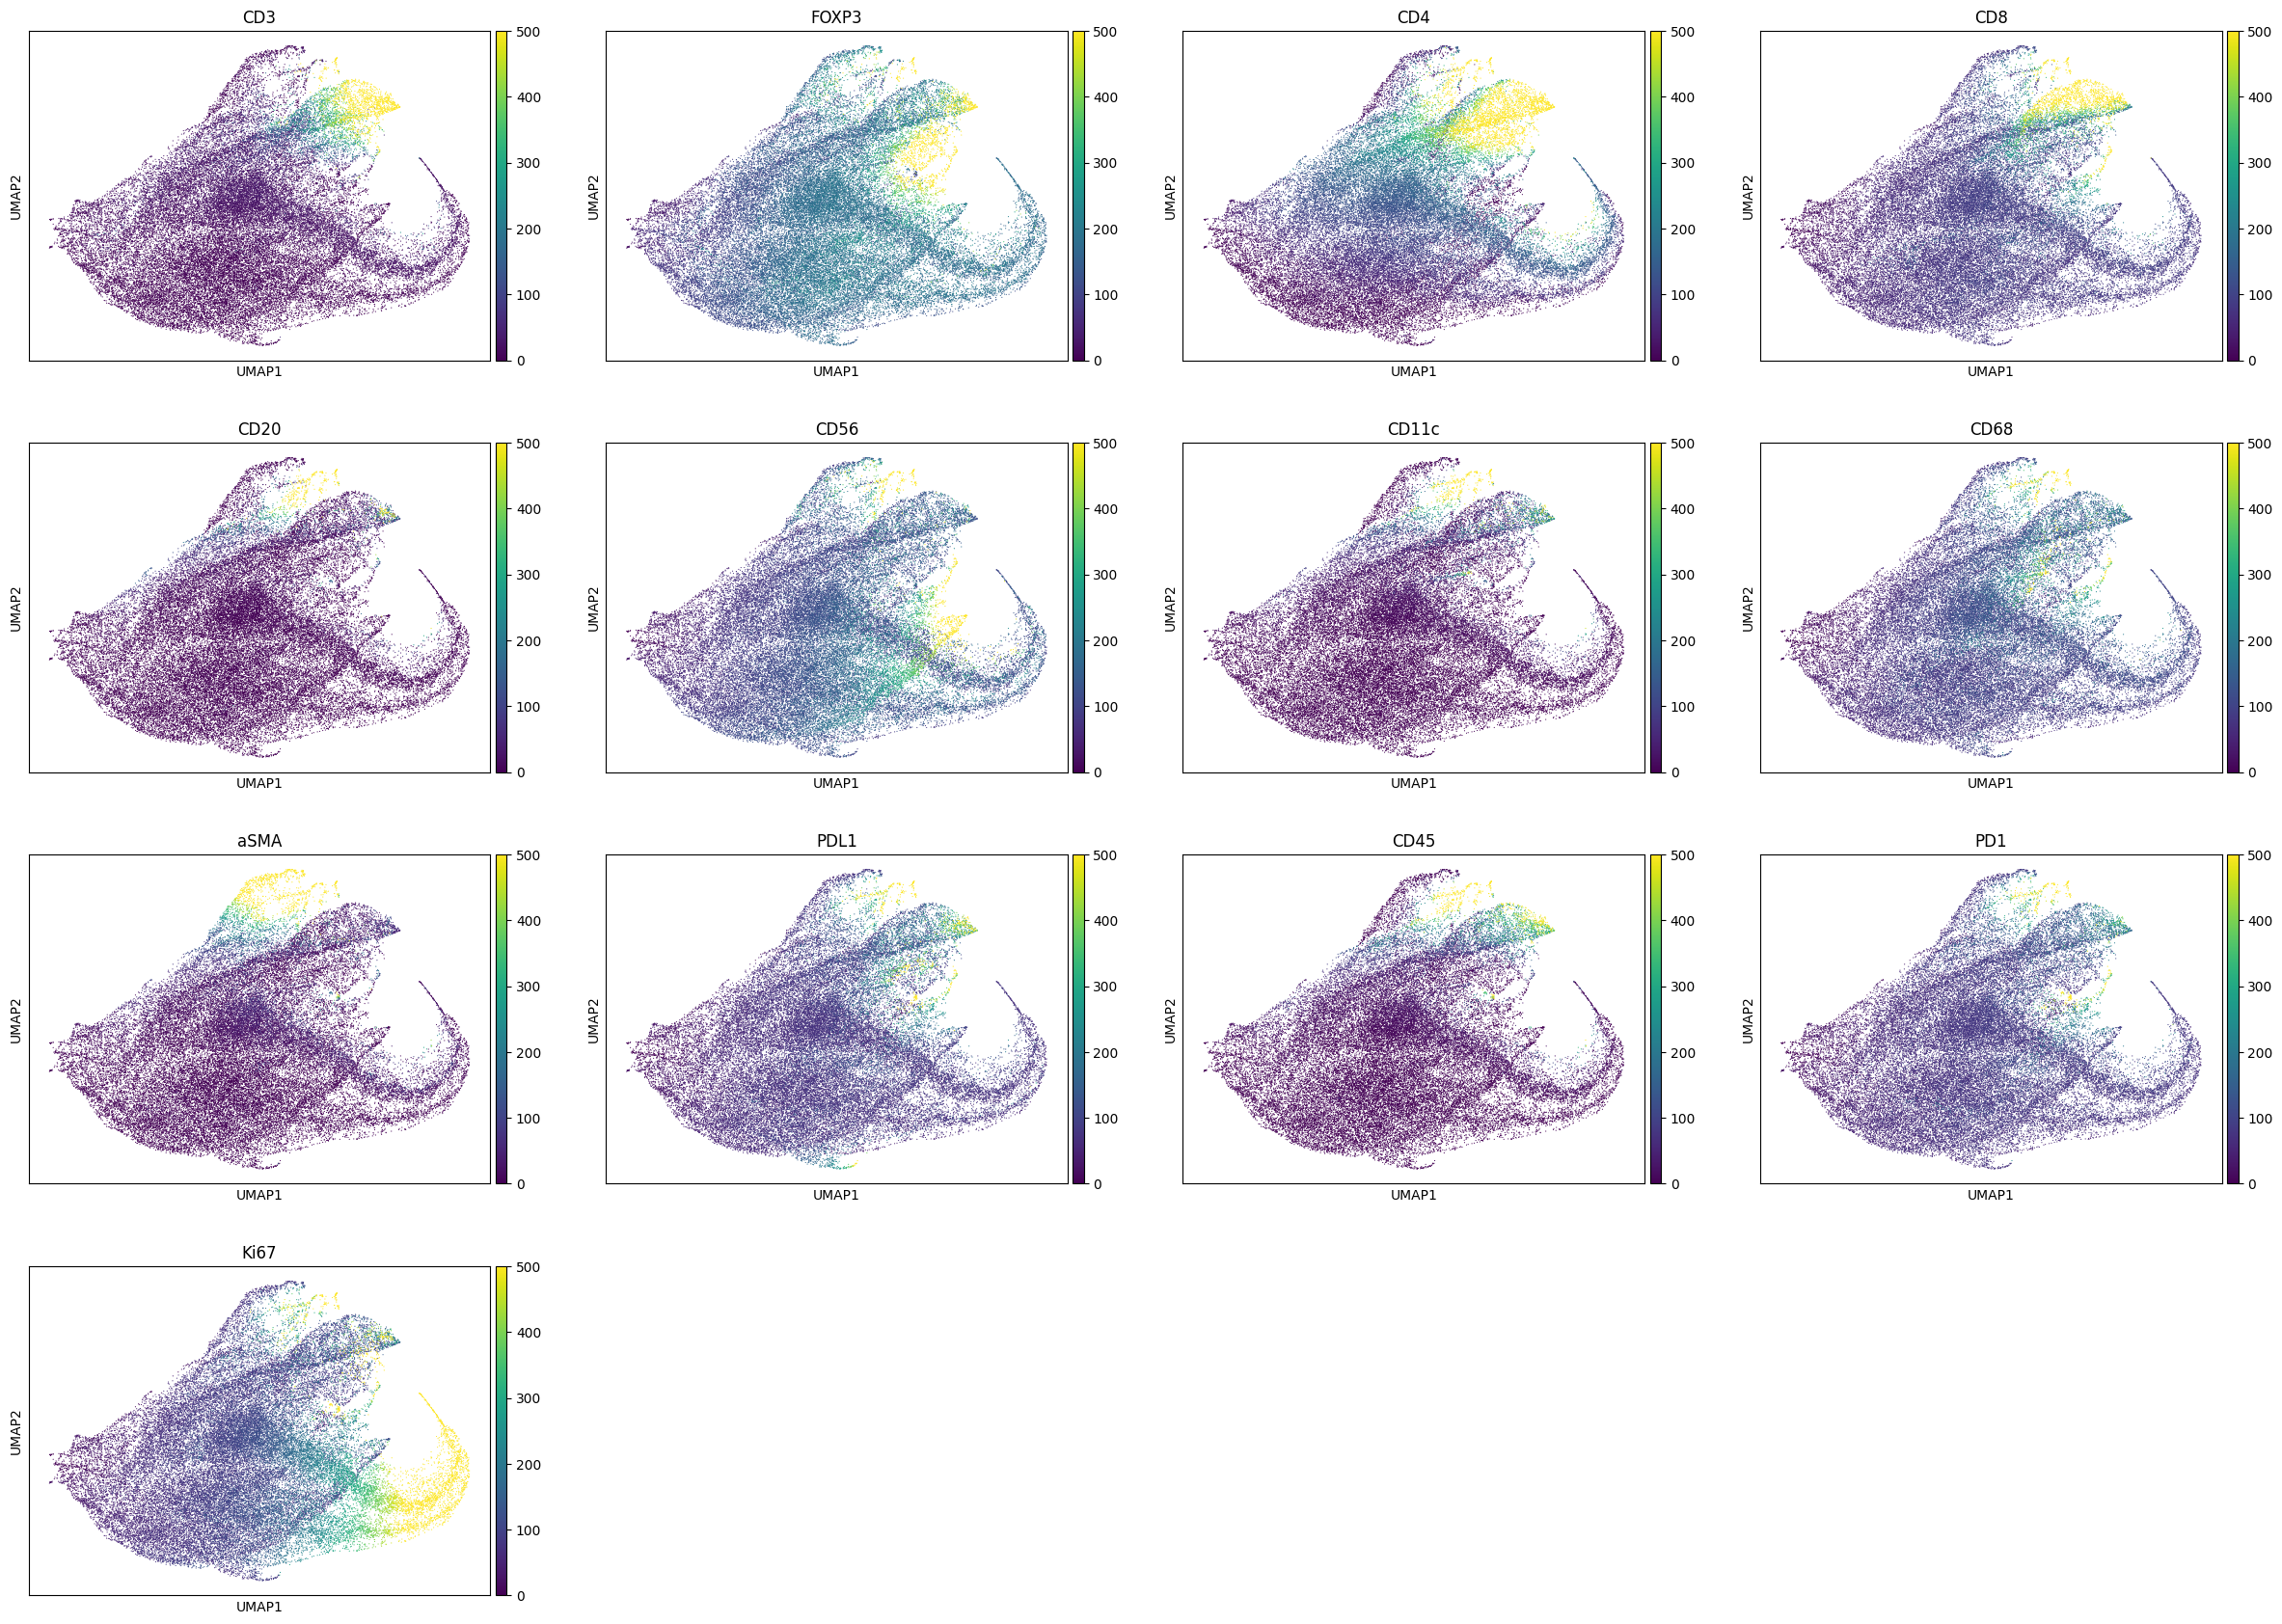

In [32]:
sc.pl.umap(
    img["nodapi"],
    color=sopa_marker_genes[1:], vmax = 500)

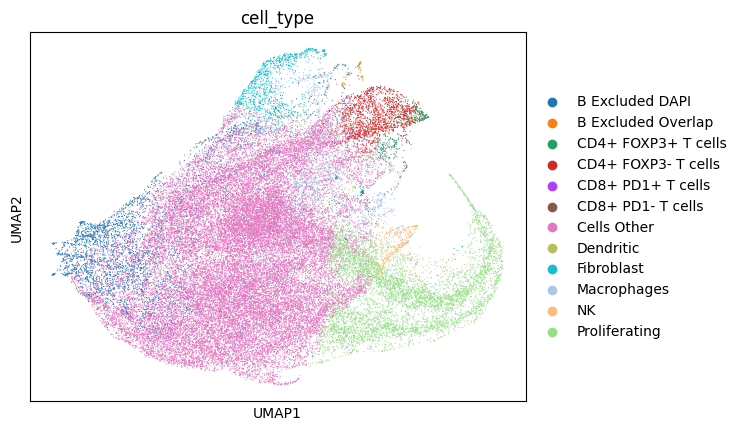

In [39]:
sc.pl.umap(
    img["nodapi"],
    color="cell_type")

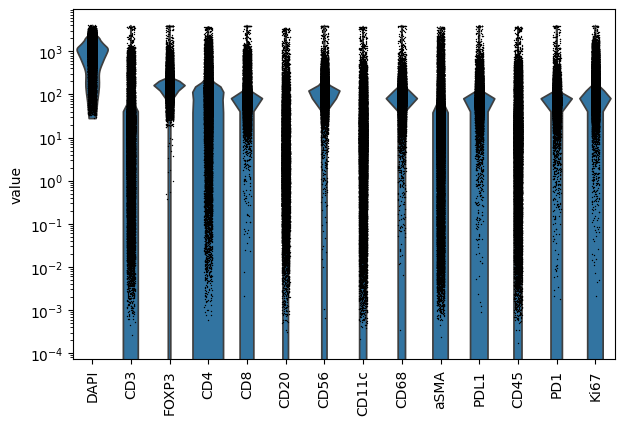

In [13]:
# Plot violin plots for each marker expression across cells
sc.pl.violin(img["table"], sopa_marker_genes, rotation=90, log=True)

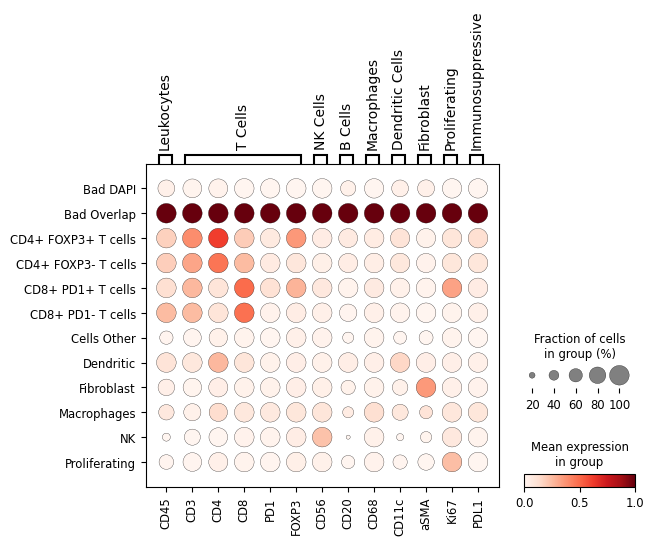

In [35]:
marker_genes = {
    "Leukocytes": ["CD45"],
    "T Cells": ["CD3", "CD4", "CD8", "PD1", "FOXP3"],
    "NK Cells": ["CD56"],
    "B Cells": ["CD20"],
    "Macrophages": ["CD68"],
    "Dendritic Cells": ["CD11c"],
    "Fibroblast": ["aSMA"],
    "Proliferating": ["Ki67"],
    "Immunosuppressive": ["PDL1"] 
}
sc.pl.dotplot(img["table"], var_names = marker_genes, groupby="cell_type", standard_scale="var", vmax = 1)

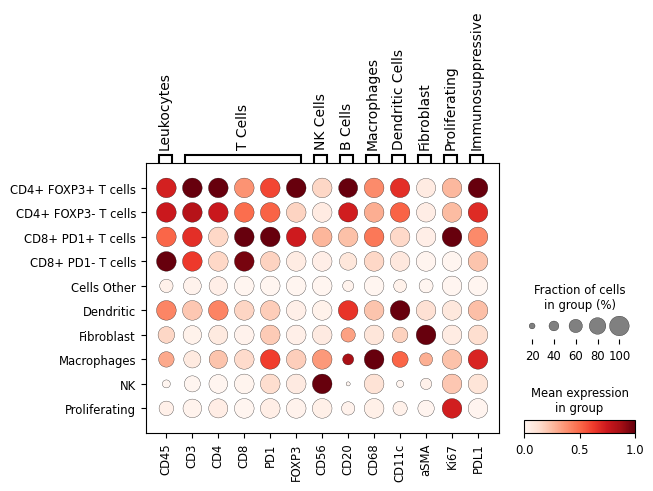

In [26]:
marker_genes = {
    "Leukocytes": ["CD45"],
    "T Cells": ["CD3", "CD4", "CD8", "PD1", "FOXP3"],
    "NK Cells": ["CD56"],
    "B Cells": ["CD20"],
    "Macrophages": ["CD68"],
    "Dendritic Cells": ["CD11c"],
    "Fibroblast": ["aSMA"],
    "Proliferating": ["Ki67"],
    "Immunosuppressive": ["PDL1"] 
}
sc.pl.dotplot(img["table"][(img["table"].obs["cell_type"] != "Bad DAPI") & (img["table"].obs["cell_type"] !=  "Bad Overlap")], var_names = marker_genes, groupby="cell_type", standard_scale="var", vmax = 1)

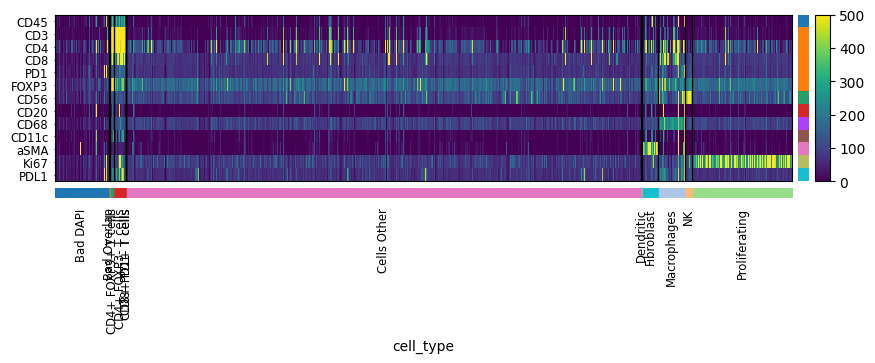

In [21]:
sc.pl.heatmap(img["table"], marker_genes, groupby='cell_type', swap_axes=True, vmax=500)

In [5]:
# Produces an expression table withou DAPI for the clustering
img["nodapi"] = img["table"][:, 1:].copy()

In [ ]:
# Generate a NN neighbour grap and the UMAP embeddings
sc.pp.neighbors(img["table"])
sc.tl.umap(img["table"])

In [19]:
# Use the bounding boxes to crop the spatialdata object
sample_list = []
for i in range(len(samples)):
    minc = np.array((samples.iloc[i].minx, samples.iloc[i].miny))
    maxc = np.array((samples.iloc[i].maxx, samples.iloc[i].maxy))
    sample_list.append(img.query.bounding_box(axes=("x", "y"), min_coordinate=minc, max_coordinate=maxc, target_coordinate_system="global"))
sample_list

[SpatialData object
 ├── Images
 │     └── 'no_elution': DataTree[cyx] (14, 8032, 14881), (14, 4016, 7441), (14, 2008, 3720), (14, 1004, 1860), (14, 501, 929)
 ├── Shapes
 │     ├── 'cells': GeoDataFrame shape: (23067, 1) (2D shapes)
 │     ├── 'image_patches': GeoDataFrame shape: (130, 3) (2D shapes)
 │     └── 'region_of_interest': GeoDataFrame shape: (1, 1) (2D shapes)
 └── Tables
       └── 'table': AnnData (23067, 14)
 with coordinate systems:
     ▸ 'global', with elements:
         no_elution (Images), cells (Shapes), image_patches (Shapes), region_of_interest (Shapes),
 SpatialData object
 ├── Images
 │     └── 'no_elution': DataTree[cyx] (14, 10672, 8112), (14, 5336, 4056), (14, 2668, 2028), (14, 1334, 1014), (14, 666, 506)
 ├── Shapes
 │     ├── 'cells': GeoDataFrame shape: (23404, 1) (2D shapes)
 │     ├── 'image_patches': GeoDataFrame shape: (90, 3) (2D shapes)
 │     └── 'region_of_interest': GeoDataFrame shape: (1, 1) (2D shapes)
 └── Tables
       └── 'table': AnnData (2

In [20]:
# Write out zarrs for visualization with napari
outpath = "CROPPED"
os.makedirs(outpath, exist_ok=True)
for i in range(len(sample_list)):
    path  = os.path.join(outpath, "sample_" + str(i) + ".zarr")
    sample_list[i].write(file_path=path, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside CROPPED/sample_0.zarr). Please see the documentation of `is_self_contained()` to        
         understand the implications of working with SpatialData objects that are not self-contained.              
INFO     The Zarr backing store has been changed from None the new file path: CROPPED/sample_0.zarr                
INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside CROPPED/sample_1.zarr). Please see the documentation of `is_self_contained()` to        
         understand the implications of working with SpatialData objects that are not self-contained.              
INFO     The Zarr backing store has been changed from None the new file path: CROPPED/sample_1.zarr                
